# 1.Dataset Preparation

In [ ]:
# All library imports
import os
import time
import shapely
import rasterio
import geopandas
import subprocess
import numpy as np
import multiprocessing
from osgeo import gdal
from shapely import wkt
from rasterio.mask import mask
from rasterio.windows import Window
from rasterio.features import rasterize
from shapely.geometry import box, mapping
from collections import Counter
from utils.ndwi_splitting import GlacialLakeDatasetProcessor
import os
import numpy as np
import rasterio
from rasterio.windows import Window
import matplotlib.pyplot as plt
from collections import Counter

# initialise all the base directories
landsat_basedirectory = '/media/user/data/new_dataset_landsat_images/landsat_images/himalayaranges' # Contains all the landsat images for the catagorised by ranges
hma_basedirectory = '/home/user/Documents/2017/hmashape_file'   # Contains the HMA glacial lake file for the year
rangeboundary_basedirectory = '/home/user/Documents/2017/range_boundaries' # Contains the custom made range boundary
rangemosaic_basedirectory = '/home/user/Documents/2017/range_mosaics' # Contains the range boundaries ofin the subfolder
clippedlakes_basedirectory = '/home/user/Documents/2017/lakes_by_range' # Contains the shape file clipped by ranges
dataset_basedirectory = '/home/user/Documents/2017/dataset/128'
shape_file_path = '/home/user/Documents/2017/hmashape_file/reprojected_2017.shp'
lake_shapefile_basedirectory = '/home/user/Documents/2017/lakes_by_range'
##################################################################################################################################################################
#tile 
for x in [128]:
    ti=x
    #mountain rage


    ##################################################################################################################################################################
    # Normalise a raster band
    def normalize_band(band):
        band_min, band_max = band.min(), band.max()
        band = (band - band_min)/(band_max - band_min)
        return band

    # Reproject raster to EPSG:32645
    def reproject_raster(raster_path):
        ''' Reproject the raster to EPSG : 32645    '''
        dst_crs = 'EPSG:32645'
        warp_options = gdal.WarpOptions(dstSRS = dst_crs, format = 'GTiff')
        source_raster = gdal.Open(raster_path)
        gdal.Warp(raster_path, source_raster, options = warp_options)

    # Clip out the HMA shapefile for the mountain ranges
    def clip_shapefile(mountain_range):
        ''' Clip out the HMA shape file for the given mountain range.'''
        rangeboundary_path = rangeboundary_basedirectory +str('/') + mountain_range + str('/') + mountain_range + str('.shp')
        outputclip_path = clippedlakes_basedirectory + str('/') + mountain_range + str('/') + mountain_range + str('.shp')
        
        # Read the mountain range boundary
        range_boundary = geopandas.read_file(rangeboundary_path) # Read the shape file for the range
        shapefile_clip = geopandas.overlay(shape_file, range_boundary, how = 'intersection')
        shapefile_clip.to_file(outputclip_path)
    #Ndwi
    import matplotlib.pyplot as plt
    import rasterio.plot

    #making rasterpyth

    def make_raster(landsat_tile, range_directory):
        landsat_tile_path = os.path.join(range_directory, landsat_tile)
        redband_path = landsat_tile_path + str("/") + landsat_tile + str("_B4.TIF")
        greenband_path = landsat_tile_path + str("/") + landsat_tile + str("_B3.TIF")
        blueband_path = landsat_tile_path + str("/") + landsat_tile + str("_B2.TIF")
        nirband_path = landsat_tile_path + str("/") + landsat_tile + str("_B5.TIF")
        swirband_path = landsat_tile_path + str("/") + landsat_tile + str("_B6.TIF")
        swirband2_path = landsat_tile_path + str("/") + landsat_tile + str("_B7.TIF")
        panband_path = landsat_tile_path + str("/") + landsat_tile + str("_B8.TIF")
        rgbnir_path = range_directory + str("/pansharpened_RGBNIR/") + landsat_tile + str(".TIF")
        pansharpened_path = range_directory + "/pansharpened_RGBNIR/" + landsat_tile + str('.TIF')

        # Open the Red, Green, Blue, NIR bands
        with rasterio.open(redband_path) as red_band:
            red = red_band.read(1)
        with rasterio.open(greenband_path) as green_band:
            green = green_band.read(1)
        with rasterio.open(blueband_path) as blue_band:
            blue = blue_band.read(1)
        with rasterio.open(nirband_path) as nir_band:
            nir = nir_band.read(1)
        with rasterio.open(swirband_path) as swir_band:
            swir = swir_band.read(1)
        with rasterio.open(swirband2_path) as swir2_band:
            swir2 = swir2_band.read(1)


        # Stack the bands into a single 3D array (bands, rows, cols)
        rgbnir = np.stack((red, green, blue, nir,swir,swir2), axis=0)

        # Copy the metadata of one of the input bands
        with rasterio.open(redband_path) as src:
            meta = src.meta

        # Update the metadata to reflect the number of layers
        meta.update(count=6)

        # Write the RGB image to a new file
        with rasterio.open(rgbnir_path, 'w', **meta) as dst:
            dst.write(rgbnir)

        # Pansharpening
        subprocess.run(["gdal_pansharpen.py",  '-b', '1', '-b', '2', '-b', '3', '-b', '4', '-b', '5','-b','6', panband_path, rgbnir_path, pansharpened_path])

        crs = red_band.crs
        source_crs = crs.to_epsg()
        if source_crs != 32645:
            reproject_raster(pansharpened_path)
        
    # Make mosaic out of all the rasters
    def create_mosaic(mountain_range):
        ''' Create a mosaic for the whole mountain range.
            Combine all the pansharpened image into a tif files'''
        
        pansharpenedimage_directory = landsat_basedirectory + str("/") + mountain_range + str("/pansharpened_RGBNIR")
        os.makedirs((os.path.join(rangemosaic_basedirectory, mountain_range)), exist_ok = True)
        
        # Set path for the output files
        output_vrt = rangemosaic_basedirectory + str("/") + mountain_range + str("/") + mountain_range + str(".vrt")
        output_tif = rangemosaic_basedirectory + str("/") + mountain_range + str("/") + mountain_range + str(".TIF")
        output_dir = os.path.dirname(output_vrt)
        if not os.path.exists(output_dir): # make directory if it does not exist
            os.makedirs(output_dir)

        # Read all the files from the folder
        image_paths = [os.path.join(pansharpenedimage_directory,image_name) for image_name in os.listdir(pansharpenedimage_directory)]
        # Create the VRT
        vrt_options = gdal.BuildVRTOptions(resolution='highest', separate=False) # Create options
        vrt = gdal.BuildVRT(output_vrt, image_paths, options=vrt_options) # Create virtual raster

        # Check if the VRT was created successfully
        if vrt is not None:
            print(f"Virtual raster created successfully at {output_vrt}")
        else:
            print("Failed to create virtual raster")

        # Create tif file
        gdal.Translate(output_tif, vrt, format='GTiff')
        # delete the vrt file

    # Clip a raster mosaic to match the geographical boundaries of a range
    def clip_mosaic(mountain_range):
        ''' Clip out the mosaic of the mountain ranges to match
            the geographical regions defined by the shape file'''
        
        rangemosaic_path = rangemosaic_basedirectory + str("/") + mountain_range + str("/") + mountain_range + str(".TIF")
        rangeboundary_path = rangeboundary_basedirectory + str("/") + mountain_range + str("/") + mountain_range + str(".shp")   
        
        # Read the files
        mountainrange_boundary = geopandas.read_file(rangeboundary_path)
        target = "EPSG:32645"
        reproj = mountainrange_boundary.to_crs(target)
        boundary_polygon = reproj.geometry.iloc[0]
        with rasterio.open(rangemosaic_path, 'r') as src:
            mountainrange_mosaic = src.read()
            output_raster, output_transform = mask(src, [mapping(boundary_polygon)], crop = True)
            output_metadata = src.meta.copy()
            output_metadata.update({
                "driver"    :   "GTiff",
                "height"    :   output_raster.shape[1],
                "width"     :   output_raster.shape[2],
                "transform" :   output_transform
            })
        
        # Write clipped mosaic to file
        output_path = rangemosaic_basedirectory + str("/") + mountain_range + str("/") + mountain_range + str("_clipped.TIF")
        with rasterio.open(output_path, "w", **output_metadata) as dst:
            dst.write(output_raster)
        print("Mosaic clipped succesfully")
    # Make crops from rasters
    
    def create_patches(mountain_range, tile_size=ti):
        # Set all the directories
        lake_shape_file_path = lake_shapefile_basedirectory + str('/') + mountain_range + str('/') + mountain_range + str('.shp')
        rangemosaic_path = rangemosaic_basedirectory + str("/") + mountain_range + str("/") + mountain_range + str('_clipped') + str(".TIF")
        rangeoutput_directory = dataset_basedirectory + str("/") + mountain_range + str("-") + str(tile_size)###########################################################################3
        patchoutput_directory = rangeoutput_directory + str("/") + str("images")
        maskoutput_directory = rangeoutput_directory + str("/") + str("masks")
        os.makedirs(patchoutput_directory, exist_ok=True)
        os.makedirs(maskoutput_directory, exist_ok=True)
        lake_shape_file = geopandas.read_file(lake_shape_file_path)

        # Read the mosaic
        src = rasterio.open(rangemosaic_path, "r")
        profile = src.profile
        patch_number = 0
        total_patches = 0
        lake_patches = 0
        lake_count_per_patch = []  # List to store the number of lakes per patch
        total_lakes = 0  # Counter for the total number of lakes

        for i in range(0, src.width, tile_size):
            for j in range(0, src.height, tile_size):
                window = Window(i, j, tile_size, tile_size)
                transform = src.window_transform(window)

                profile.update({
                    'height': tile_size,
                    'width': tile_size,
                    'transform': transform
                })

                image_data = src.read(window=window)  # Get the patch
                patch_bounds = rasterio.windows.bounds(window, src.transform)  # Get the geographical bounds of patch
                nodata = src.nodata

                # Get the percent non-visible region
                nodata_count = np.count_nonzero(image_data == nodata)
                total_pixels = image_data.size
                nodata_percent = (nodata_count / total_pixels) * 100
                data_percent = 100 - nodata_percent

                # Create bounding box for cropping shape file
                crop_box = box(patch_bounds[0], patch_bounds[1], patch_bounds[2], patch_bounds[3])
                shapefile_patch = geopandas.clip(lake_shape_file, crop_box)  # Get the shape patch to raster

                # Proceed only if the shapefile_patch is not empty (contains lakes)
                if data_percent == 100:
                    total_patches += 1  # Increment total patches with data percent > 0
                    if not shapefile_patch.empty:
                        lake_patches += 1
                        patch_number += 1
                        patchoutput_filepath = patchoutput_directory + str("/") + str(patch_number) + str('.TIF')
                        maskoutput_filepath = maskoutput_directory + str("/") + str(patch_number) + str('.TIF')

                        # Count the number of lakes in this patch
                        num_lakes = len(shapefile_patch)
                        lake_count_per_patch.append(num_lakes)
                        total_lakes += num_lakes
                        #print(f"Patch {patch_number} contains {num_lakes} lakes.")

                        # Make segmentation mask
                        shapes = [(geom, 1) for geom in shapefile_patch.geometry]  # Get the polygons from the shape file
                        if len(shapes) > 0:
                            segmask = rasterize(shapes, out_shape=(tile_size, tile_size),  # Create a segmentation mask
                                                transform=transform, fill=0, dtype=np.uint8)
                        else:
                            segmask = np.zeros(shape=(tile_size, tile_size), dtype=rasterio.uint8)

                        # Write the patch
                        with rasterio.open(patchoutput_filepath, 'w', **profile) as dst_image:
                            dst_image.write(image_data)

                        # Write the segmentation mask
                        with rasterio.open(maskoutput_filepath, 'w', driver="GTiff", height=tile_size, width=tile_size, count=1, crs=src.crs,
                                        transform=transform, dtype=segmask.dtype) as dst:
                            dst.write(segmask, 1)

        # Compute the average number of lakes per patch containing lakes
        avg_lakes_per_patch = total_lakes / lake_patches if lake_patches > 0 else 0
        # Prepare the content to write
        content = (f"{mountain_range}: Total patches with data== 100 : {total_patches}, Patches with lakes: {lake_patches}\n"
            f"Total number of lakes: {total_lakes}\n"
            f"Average number of lakes per patch containing lakes: {avg_lakes_per_patch:.2f}\n")

    # Define the summary file path
        summary_file_path = os.path.join(rangeoutput_directory, 'summarypatch.txt')

    # Write the content to a text file
        with open(summary_file_path, 'w') as file:
            file.write(content)

        print(f"Summary saved to {summary_file_path}")

        print(f"{mountain_range}: Total patches with data== 100 : {total_patches}, Patches with lakes: {lake_patches}")
        print(f"Total number of lakes: {total_lakes}")
        print(f"Average number of lakes per patch containing lakes: {avg_lakes_per_patch}")
    
        #print(f"Lake count per patch: {lake_count_per_patch}")
        lake_counts = Counter(lake_count_per_patch)
        num_lakes_unique = list(lake_counts.keys())
        num_patches = list(lake_counts.values())

        plt.bar(num_lakes_unique, num_patches, color='skyblue')
        plt.xlabel('Number of Lakes')
        plt.ylabel('Number of Patches')
        plt.title('Distribution of Number of Lakes Across Patches')
        plt.xticks(num_lakes_unique)  # Ensure each x-tick is shown
        plt.savefig(rangeoutput_directory + '/plot.png')


  
            
    def processmountain_range(each_range):
        print(f"Processing tilesize={x} ,for= {each_range}")
        range_directory = os.path.join(landsat_basedirectory, each_range)  # Get the directory of the range
        landsat_images = [img for img in os.listdir(range_directory) if img not in ["pansharpened_RGBNIR", "rgbnir","ndwi_after","ndwi_before"]]  # Get all the landsat images for a range excluding specific directories
        print(landsat_images)
        os.makedirs(os.path.join(range_directory, "rgbnir"), exist_ok=True)
        os.makedirs(os.path.join(range_directory, "pansharpened_RGBNIR"), exist_ok=True)
        pansharpenedRGBNIR_directory = range_directory + "/pansharpened_RGBNIR"

        # make the pansharpened RGBNIr for all landsat images
        for each_image in landsat_images:
            make_raster(each_image, range_directory)

        print("Finished making rasters for ", each_range)
        create_mosaic(each_range) # make mosaic for the mountain being processed
        clip_mosaic(each_range) # Filter out the regions falling out of the range boundary
        create_patches(each_range) # Create patches out of the clipped mosaic

    if __name__ == "__main__":

        start_time = time.time()
    ############################################################################################################################################
        def get_folder_names(directory):
    # Get a list of all entries in the directory
            entries = os.listdir(directory)
            # Filter to include only directories
            folder_names = [entry for entry in entries if os.path.isdir(os.path.join(directory, entry))]
            return folder_names

      
        m = ['eastern_himalaya']
       

        for i in m:
            # if x == 256 and i in ['central_himalaya', 'eastern_himalaya']:
                # continue  # Skip this iteration for central and eastern himalaya when x == 128
            
            # Code for other operations
            mountain_ranges = [i]
            

            ## Tile _size
            

        ###########################################################################################################################################
            shape_file = geopandas.read_file(shape_file_path) # Load the HMA shape file as global variable
            with multiprocessing.Pool(processes = 30) as pool:
                pool.map(processmountain_range, mountain_ranges)
            total = (time.time() - start_time) / 3600
            print(total)
        #     base_directory =dataset_basedirectory + str("/") + mountain_ranges[0] + str("-")+str(ti)
        #     out_ndwi_subfolder_name = f"NDWI_{ti}"
        #     out_datav = f"splitting_{ti}"
        #     processor = GlacialLakeDatasetProcessor(base_directory, out_ndwi_subfolder_name, out_datav)
        #     processor.process_and_split (seed=42)
        # print(f"tile_size={x} for {i} completed")

Processing tilesize=128 ,for= gangdise_mountains
['LC08_L1TP_144039_20171017_20200902_02_T1', 'LC08_L1TP_146038_20171031_20200902_02_T1', 'LC08_L1TP_140039_20171005_20200903_02_T1', 'LC08_L1TP_143039_20171010_20200903_02_T1', 'LC08_L1TP_138039_20171023_20200902_02_T1', 'LC08_L1TP_145038_20171008_20200903_02_T1', 'LC08_L1TP_142039_20171003_20200903_02_T1', 'LC08_L1TP_146037_20170913_20200903_02_T1', 'LC08_L1TP_144038_20170915_20200903_02_T1', 'LC08_L1TP_139039_20171115_20200902_02_T1', 'LC08_L1TP_145037_20170821_20200903_02_T1', 'LC08_L1TP_141039_20170926_20200903_02_T1', 'LC08_L1TP_141040_20171113_20200902_02_T1', 'LC08_L1TP_140040_20171005_20200903_02_T1', 'LC08_L1TP_143038_20171010_20200903_02_T1', 'LC08_L1TP_139040_20171030_20200902_02_T1']
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0.

# 2.Make Slope and DEm mosaic in float 32 

In [ ]:
import os
from utils.dem_process import DEMProcessor, LandsatSlopeCombiner,Datset2
mon= ["eastern_hindu_kush"]

for j in mon:
    print(j)
    dem_directory = f"/media/user/data/new_dataset_landsat_images/landsat_images/dem/{j}"
    rangeboundary_path = f"/home/user/Documents/2017/range_boundaries/{j}/{j}.shp"
    landsat_mosaic_path = f"/home/user/Documents/2017/range_mosaics/{j}/{j}_clipped.TIF"
    output_directory = f"/media/user/data/new_dataset_landsat_images/combined_mosaic_landsat_dem_slope/{j}"
    os.makedirs(output_directory,exist_ok=True)

    processor = DEMProcessor(dem_directory, rangeboundary_path, landsat_mosaic_path, output_directory)
    processor.create_mosaic()

eastern_hindu_kush
Reprojecting shapefile to EPSG:32645
Virtual raster created successfully at /media/user/data/new_dataset_landsat_images/combined_mosaic_landsat_dem_slope/eastern_hindu_kush/mosaic.vrt
Mosaic created successfully at /media/user/data/new_dataset_landsat_images/combined_mosaic_landsat_dem_slope/eastern_hindu_kush/DEM.TIF
Raster reprojected to EPSG:32645: /media/user/data/new_dataset_landsat_images/combined_mosaic_landsat_dem_slope/eastern_hindu_kush/DEM.TIF
Generating slope from DEM: /media/user/data/new_dataset_landsat_images/combined_mosaic_landsat_dem_slope/eastern_hindu_kush/DEM.TIF
Slope generated successfully at /media/user/data/new_dataset_landsat_images/combined_mosaic_landsat_dem_slope/eastern_hindu_kush/slope.TIF
Extracted Resolution from /home/user/Documents/2017/range_mosaics/eastern_hindu_kush/eastern_hindu_kush_clipped.TIF: 15.264649027400324, 15.264649027400324
Resampling raster to 15.264649027400324m resolution: /media/user/data/new_dataset_landsat_image

## combining slope and dem in landsat 128 tiles


In [ ]:
import os
import rasterio
from rasterio.mask import mask
from shapely.geometry import box
from rasterio.warp import transform_bounds, reproject, Resampling
import numpy as np

import shutil
import os
class RasterProcessor:
    def __init__(self, landsat_dir, mask_dir, slope_raster, dem_raster, output_dir, merged_output_dir):
        self.landsat_dir = landsat_dir
        self.mask_dir = mask_dir
        self.slope_raster = slope_raster
        self.dem_raster = dem_raster
        self.output_dir = output_dir
        self.merged_output_dir = merged_output_dir
        os.makedirs(output_dir, exist_ok=True)
        os.makedirs(merged_output_dir, exist_ok=True)


    def delete_directory(self,directory_path):
        if os.path.exists(directory_path):
            shutil.rmtree(directory_path)
            print(f"Deleted directory: {directory_path}")
        else:
            print(f"Directory does not exist: {directory_path}")

    def clip_raster(self, input_raster, mask_raster, output_raster):
        with rasterio.open(mask_raster) as mask_src:
            mask_bounds = mask_src.bounds
            mask_crs = mask_src.crs
            mask_transform = mask_src.transform
            mask_width, mask_height = mask_src.width, mask_src.height

            with rasterio.open(input_raster) as src:
                if src.crs != mask_crs:
                    input_bounds = transform_bounds(src.crs, mask_crs, *src.bounds)
                else:
                    input_bounds = src.bounds
                
                geometry_box = [box(*mask_bounds)]
                geometry_box = [{"type": "Polygon", "coordinates": [list(geometry_box[0].exterior.coords)]}]
                
                clipped_data, clipped_transform = mask(src, geometry_box, crop=True)
                resampled_data = np.zeros((clipped_data.shape[0], mask_height, mask_width), dtype=np.float32)
                
                for i in range(clipped_data.shape[0]):
                    resampled_data[i, :, :], _ = reproject(
                        source=clipped_data[i, :, :],
                        destination=np.empty((mask_height, mask_width), dtype=np.float32),
                        src_transform=clipped_transform,
                        src_crs=mask_crs,
                        dst_transform=mask_transform,
                        dst_crs=mask_crs,
                        resampling=Resampling.nearest,
                    )

                clipped_meta = mask_src.meta.copy()
                clipped_meta.update({"driver": "GTiff", "dtype": "float32", "height": mask_height, "width": mask_width, "transform": mask_transform, "crs": mask_crs})
                
                with rasterio.open(output_raster, "w", **clipped_meta) as dst:
                    dst.write(resampled_data)

    def merge_rasters(self, landsat_raster, slope_raster, dem_raster, output_raster):
        with rasterio.open(landsat_raster) as landsat_src:
            landsat_data = landsat_src.read().astype(np.float32)
            landsat_meta = landsat_src.meta
        
        with rasterio.open(slope_raster) as slope_src:
            slope_data = slope_src.read(1).astype(np.float32)
            slope_data = np.expand_dims(slope_data, axis=0)
        
        with rasterio.open(dem_raster) as dem_src:
            dem_data = dem_src.read(1).astype(np.float32)
            dem_data = np.expand_dims(dem_data, axis=0)
        
        landsat_meta.update({"count": landsat_data.shape[0] + 2, "dtype": "float32"})
        combined_data = np.concatenate((landsat_data, slope_data, dem_data), axis=0)

        with rasterio.open(output_raster, "w", **landsat_meta) as dst:
            dst.write(combined_data)

    def process(self):
        for mask_file in os.listdir(self.mask_dir):
            if mask_file.endswith(".TIF"):
                mask_path = os.path.join(self.mask_dir, mask_file)
                clipped_slope_path = os.path.join(self.output_dir, f"slope_{mask_file}")
                clipped_dem_path = os.path.join(self.output_dir, f"dem_{mask_file}")
                landsat_path = os.path.join(self.landsat_dir, mask_file)
                merged_output_path = os.path.join(self.merged_output_dir, mask_file)
                
                print(f"Processing: {mask_file}")
                self.clip_raster(self.slope_raster, mask_path, clipped_slope_path)
                self.clip_raster(self.dem_raster, mask_path, clipped_dem_path)
                self.merge_rasters(landsat_path, clipped_slope_path, clipped_dem_path, merged_output_path)
                print(f"Saved merged raster: {mask_file}")
        self.delete_directory(self.output_dir)
   

# Define paths
for i in ["eastern_himalaya"]:
    print(i)
    slope_raster_path = f"/media/user/data/new_dataset_landsat_images/combined_mosaic_landsat_dem_slope/{i}/mosaic_clipped.TIF"
    dem_raster_path = f"/media/user/data/new_dataset_landsat_images/combined_mosaic_landsat_dem_slope/{i}/DEM.TIF"
    base_path = f"/home/user/Documents/2017/dataset/128/eastern_himalaya-256"
    landsat_dir = f"{base_path}/images"
    mask_dir = f"{base_path}/masks"
    output_dir = f"{base_path}/clipped_data"
    merged_output_dir = f"{base_path}/mergimages"

    # Run processing
    processor = RasterProcessor(landsat_dir, mask_dir, slope_raster_path, dem_raster_path, output_dir, merged_output_dir)
    processor.process()
    print("Processing complete.")

eastern_himalaya
Processing: 1024.TIF
Saved merged raster: 1024.TIF
Processing: 944.TIF
Saved merged raster: 944.TIF
Processing: 222.TIF
Saved merged raster: 222.TIF
Processing: 16.TIF
Saved merged raster: 16.TIF
Processing: 205.TIF
Saved merged raster: 205.TIF
Processing: 115.TIF
Saved merged raster: 115.TIF
Processing: 938.TIF
Saved merged raster: 938.TIF
Processing: 274.TIF
Saved merged raster: 274.TIF
Processing: 672.TIF
Saved merged raster: 672.TIF
Processing: 254.TIF
Saved merged raster: 254.TIF
Processing: 968.TIF
Saved merged raster: 968.TIF
Processing: 278.TIF
Saved merged raster: 278.TIF
Processing: 216.TIF
Saved merged raster: 216.TIF
Processing: 641.TIF
Saved merged raster: 641.TIF
Processing: 1043.TIF
Saved merged raster: 1043.TIF
Processing: 258.TIF
Saved merged raster: 258.TIF
Processing: 513.TIF
Saved merged raster: 513.TIF
Processing: 148.TIF
Saved merged raster: 148.TIF
Processing: 577.TIF
Saved merged raster: 577.TIF
Processing: 102.TIF
Saved merged raster: 102.TIF
P

# data Preprocessing---Filtering--normalization--splitting (Threshold value is excluded so decide on that basis)

In [ ]:
import os
import numpy as np
import rasterio
import shutil
import random
from glob import glob

class LakeDatasetPreprocessor:
    def __init__(self, image_dir, mask_dir, output_dir, pixel_threshold=20, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, random_state=42):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.output_dir = output_dir
        self.pixel_threshold = pixel_threshold
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.test_ratio = test_ratio
        self.random_state = random_state

        self.normalized_dir = os.path.join(self.output_dir, "normalization")
        self.splits_dir = os.path.join(self.output_dir, "splitted")

        os.makedirs(self.normalized_dir + "/images", exist_ok=True)
        os.makedirs(self.normalized_dir + "/masks", exist_ok=True)

    def normalize_and_filter(self):
        image_files = [f for f in os.listdir(self.image_dir) if f.endswith(".TIF")]

        for file in image_files:
            image_path = os.path.join(self.image_dir, file)
            mask_path = os.path.join(self.mask_dir, file)

            if not os.path.exists(mask_path):
                continue

            with rasterio.open(mask_path) as m:
                mask = m.read(1)
                if np.sum(mask > 0) <self.pixel_threshold:
                    continue

            try:
                with rasterio.open(image_path) as src:
                    rgb = src.read([1, 2, 3, 4, 5, 6]).astype("float32")
                    rgb /= 65536

                    green = src.read(2).astype("float32")
                    nir = src.read(4).astype("float32")
                    swir1 = src.read(5).astype("float32")
                    slope = src.read(7).astype("float32")
                    dem = src.read(8).astype("float32")

                    ndwi = (green - nir) / (green + nir + 1e-10)
                    ndsi = (green - swir1) / (green + swir1 + 1e-10)

                    stacked = np.concatenate([
                        rgb,
                        np.expand_dims(ndwi, axis=0),
                        np.expand_dims(ndsi, axis=0),
                        np.expand_dims(slope / 90, axis=0),
                        np.expand_dims(dem / 10000, axis=0),
                    
                        
                    ], axis=0)

                    out_img_path = os.path.join(self.normalized_dir, "images", file)
                    out_mask_path = os.path.join(self.normalized_dir, "masks", file)

                    with rasterio.open(out_img_path, 'w', driver='GTiff',
                                       height=src.height, width=src.width,
                                       count=stacked.shape[0], dtype='float32',
                                       crs=src.crs, transform=src.transform) as dst:
                        dst.write(stacked)

                    with rasterio.open(mask_path) as mask_src:
                        mask_data = mask_src.read(1).astype("uint8")
                        with rasterio.open(out_mask_path, 'w', driver='GTiff',
                                           height=mask_src.height, width=mask_src.width,
                                           count=1, dtype='uint8',
                                           crs=mask_src.crs, transform=mask_src.transform) as dst:
                            dst.write(mask_data, 1)

            except Exception as e:
                print(f"Error processing {file}: {e}")
                continue

    def split_dataset(self):
        img_dir = os.path.join(self.normalized_dir, "images")
        msk_dir = os.path.join(self.normalized_dir, "masks")

        image_files = glob(os.path.join(img_dir, "*.TIF"))
        mask_files = glob(os.path.join(msk_dir, "*.TIF"))

        mask_dict = {os.path.basename(m).replace(".tif", ""): m for m in mask_files}
        pairs = [(img, mask_dict.get(os.path.basename(img).replace(".tif", "")))
                 for img in image_files if os.path.basename(img).replace(".tif", "") in mask_dict]

        random.seed(self.random_state)
        random.shuffle(pairs)

        total = len(pairs)
        train_cnt = int(total * self.train_ratio)
        val_cnt = int(total * self.val_ratio)
        test_cnt = total - train_cnt - val_cnt

        splits = {
            'training': pairs[:train_cnt],
            'validation': pairs[train_cnt:train_cnt+val_cnt],
            'test': pairs[train_cnt+val_cnt:]
        }

        for split_name, split_pairs in splits.items():
            for sub in ["images", "masks"]:
                os.makedirs(os.path.join(self.splits_dir, split_name, sub), exist_ok=True)

            for img, msk in split_pairs:
                shutil.copy(img, os.path.join(self.splits_dir, split_name, "images"))
                shutil.copy(msk, os.path.join(self.splits_dir, split_name, "masks"))

        print(f"Split completed: {total} total → {train_cnt} train, {val_cnt} val, {test_cnt} test")

    def run_pipeline(self):
        print("Normalizing and filtering...")
        self.normalize_and_filter()
        print("Splitting dataset...")
        self.split_dataset()
        print("✅ Done: Normalized and Split dataset ready at:", self.splits_dir)
if __name__ == "__main__":

    dir="/home/user/Documents/2017/dataset/128/eastern_himalaya-256"
    image_dir = f"{dir}/images"
    mask_dir = f"{dir}/masks"
    output_dir = f"{dir}/preprocess_divide_65536"
  

    processor = LakeDatasetPreprocessor(image_dir, mask_dir, output_dir)
    processor.run_pipeline()


Normalizing and filtering...
Splitting dataset...
Split completed: 1043 total → 730 train, 208 val, 105 test
✅ Done: Normalized and Split dataset ready at: /home/user/Documents/2017/dataset/128/eastern_himalaya-256/preprocess_divide_65536/splitted


# Analysis

## For eastern_himalaya

100%|██████████| 1322/1322 [00:18<00:00, 70.04it/s]


Band            |   Bhattacharyya |  Wasserstein |  KS-Stat
-------------------------------------------------------


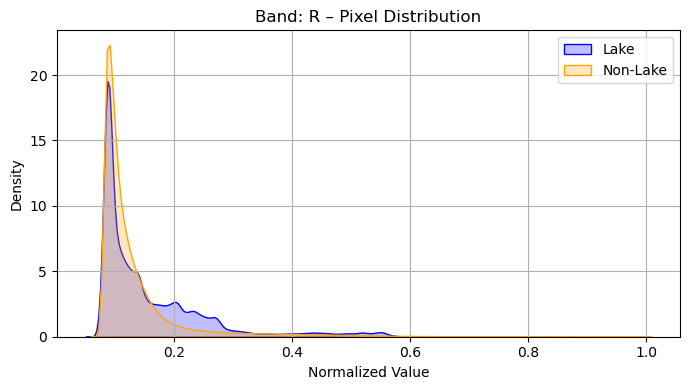

R               |          0.0481 |       0.0244 |   0.1651


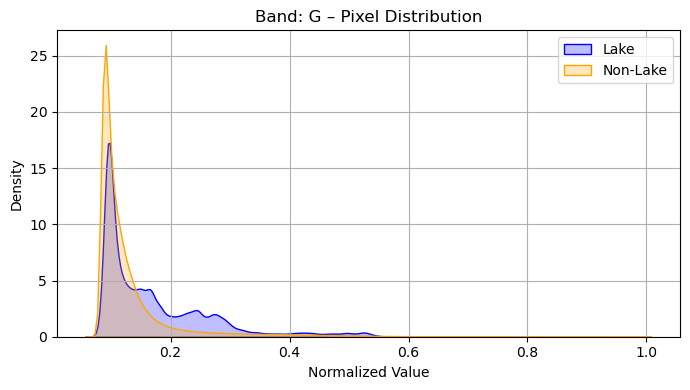

G               |          0.1012 |       0.0393 |   0.2652


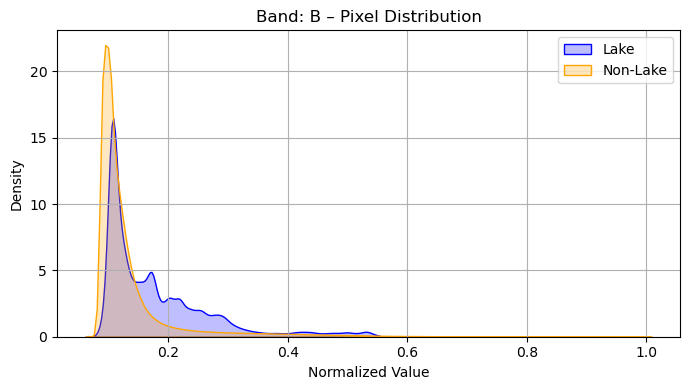

B               |          0.1374 |       0.0436 |   0.3281


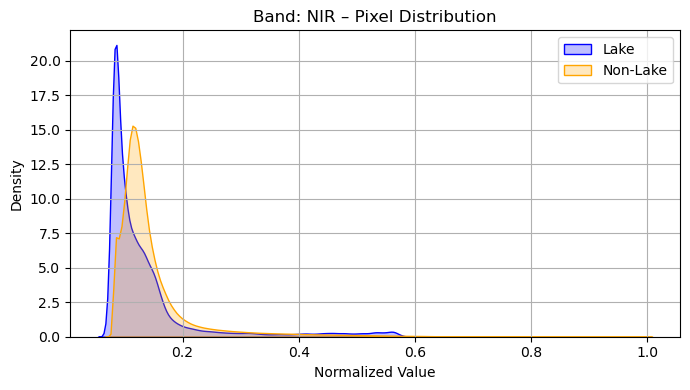

NIR             |          0.0827 |       0.0191 |   0.3107


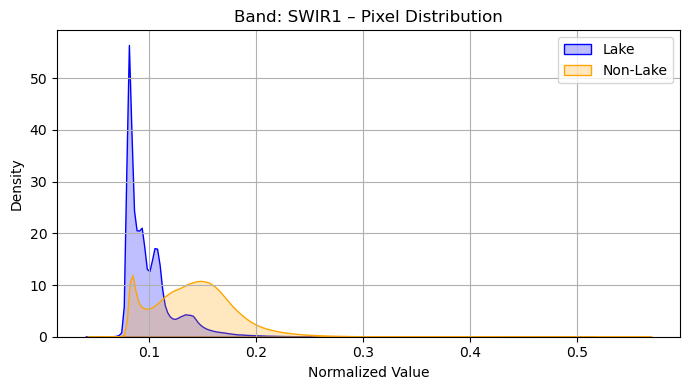

SWIR1           |          0.2211 |       0.0411 |   0.5640


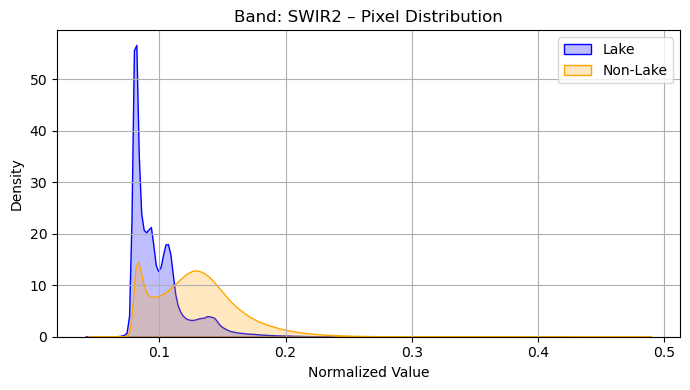

SWIR2           |          0.1549 |       0.0301 |   0.4915


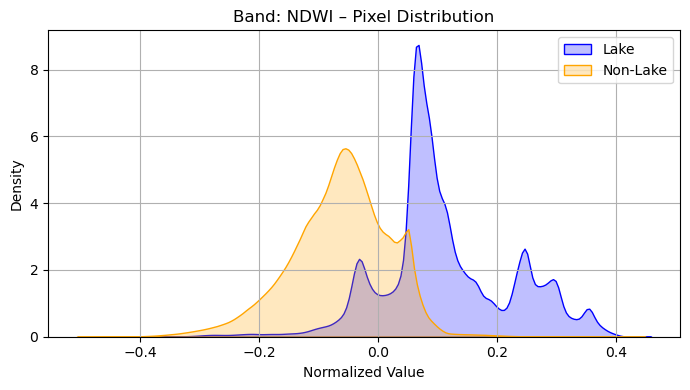

NDWI            |          0.3684 |       0.1751 |   0.7212


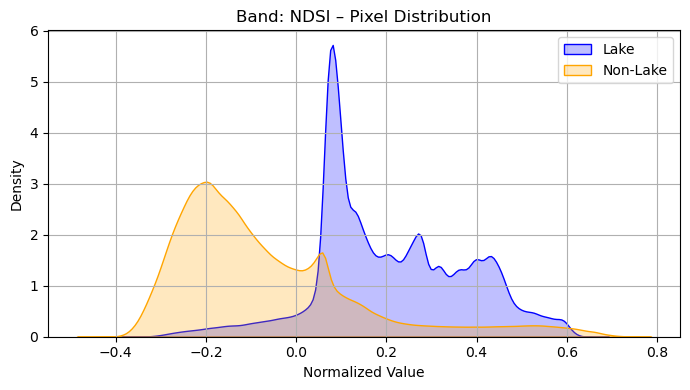

NDSI            |          0.1107 |       0.2753 |   0.6916


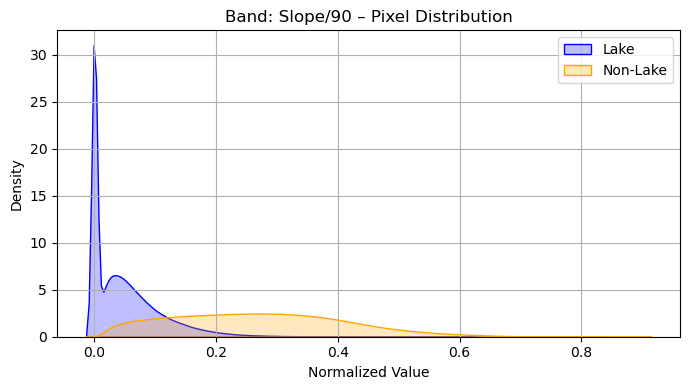

Slope/90        |          0.5920 |       0.2191 |   0.7104


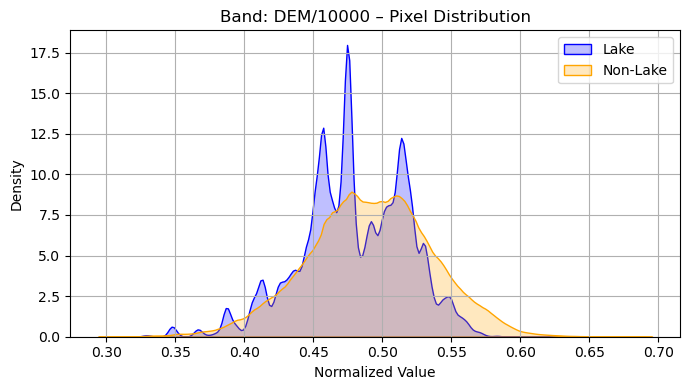

DEM/10000       |          0.0356 |       0.0119 |   0.1434


In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import wasserstein_distance, ks_2samp

# === SETUP ===
images_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/training/images"
masks_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/training/masks"

band_indices = list(range(10))  # Bands 0 to 9
band_names = ["R", "G", "B", "NIR", "SWIR1", "SWIR2", "NDWI", "NDSI", "Slope/90", "DEM/10000"]

lake_pixels = {band: [] for band in band_names}
nonlake_pixels = {band: [] for band in band_names}

image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith(".tif")])

# === EXTRACTION ===
for file in tqdm(image_files):
    image_path = os.path.join(images_dir, file)
    mask_path = os.path.join(masks_dir, file)

    with rasterio.open(image_path) as src:
        img = src.read().astype(np.float32)  # shape: (bands, H, W)

    with rasterio.open(mask_path) as src:
        mask = src.read(1).astype(bool)  # Note: bands in rasterio start at 1

    for idx, band in zip(band_indices, band_names):
        band_data = img[idx]
        lake_pixels[band].extend(band_data[mask].flatten())
        nonlake_pixels[band].extend(band_data[~mask].flatten())

# === ANALYSIS FUNCTION ===
def bhattacharyya_distance(hist1, hist2):
    coeff = np.sum(np.sqrt(hist1 * hist2))
    coeff = np.clip(coeff, 1e-10, 1)  # Avoid log(0) or log of values >1
    return -np.log(coeff)

# === PLOTTING + METRICS ===
print(f"{'Band':<15} | {'Bhattacharyya':>15} | {'Wasserstein':>12} | {'KS-Stat':>8}")
print("-" * 55)

for band in band_names:
    lake_vals = np.array(lake_pixels[band])
    nonlake_vals = np.array(nonlake_pixels[band])

    # KDE Plot
    plt.figure(figsize=(7, 4))
    sns.kdeplot(lake_vals, label="Lake", fill=True, color="blue")
    sns.kdeplot(nonlake_vals, label="Non-Lake", fill=True, color="orange")
    plt.title(f"Band: {band} – Pixel Distribution")
    plt.xlabel("Normalized Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute histograms for Bhattacharyya (PMF, not PDF)
    hist_lake, _ = np.histogram(lake_vals, bins=100, range=(0, 1), density=False)
    hist_nonlake, _ = np.histogram(nonlake_vals, bins=100, range=(0, 1), density=False)

    # Normalize to get probability distributions
    hist_lake = hist_lake / np.sum(hist_lake)
    hist_nonlake = hist_nonlake / np.sum(hist_nonlake)

    # Compute distances
    bhatt = bhattacharyya_distance(hist_lake, hist_nonlake)
    wass = wasserstein_distance(lake_vals, nonlake_vals)
    ks_stat, _ = ks_2samp(lake_vals, nonlake_vals)

    print(f"{band:<15} | {bhatt:>15.4f} | {wass:>12.4f} | {ks_stat:>8.4f}")


## For central Himalaya

100%|██████████| 1203/1203 [00:08<00:00, 149.65it/s]
/tmp/ipykernel_1659110/1236011866.py:61: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(lake_vals, label="Lake", shade=True, color="blue")


Band            |   Bhattacharyya |  Wasserstein |  KS-Stat
-------------------------------------------------------


/tmp/ipykernel_1659110/1236011866.py:62: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonlake_vals, label="Non-Lake", shade=True, color="orange")


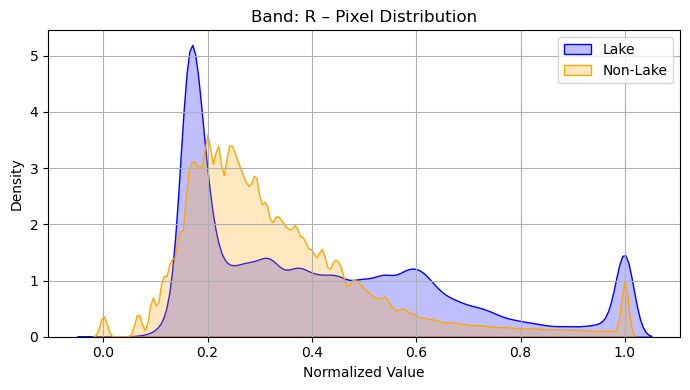

R               |         -4.5311 |       0.0891 |   0.1948


/tmp/ipykernel_1659110/1236011866.py:61: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(lake_vals, label="Lake", shade=True, color="blue")
/tmp/ipykernel_1659110/1236011866.py:62: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonlake_vals, label="Non-Lake", shade=True, color="orange")


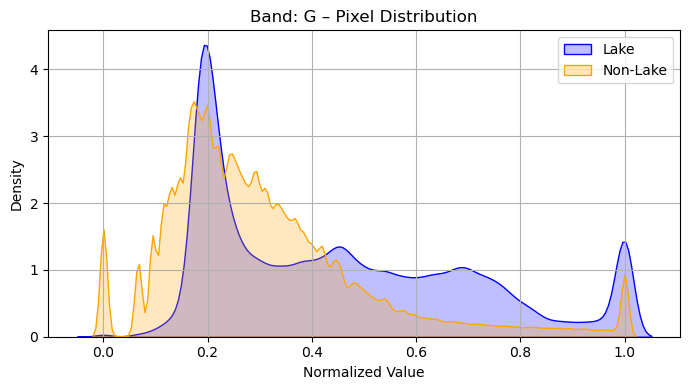

G               |         -4.4958 |       0.1467 |   0.2813


/tmp/ipykernel_1659110/1236011866.py:61: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(lake_vals, label="Lake", shade=True, color="blue")
/tmp/ipykernel_1659110/1236011866.py:62: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nonlake_vals, label="Non-Lake", shade=True, color="orange")


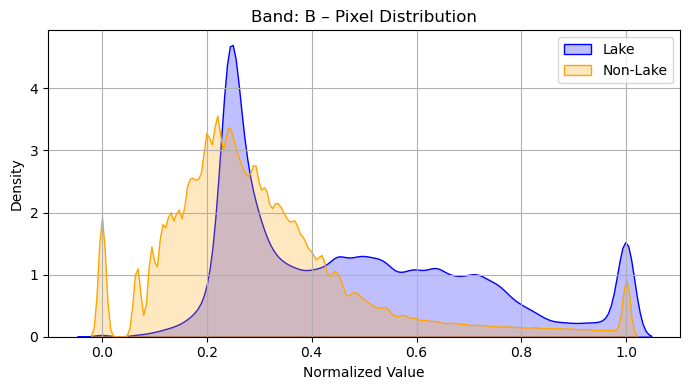

B               |         -4.4554 |       0.1706 |   0.3248


In [ ]:

import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.metrics import pairwise_distances
from math import log, sqrt

import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# === SETUP ===
images_dir = "/home/user/Documents/2017/range_mosaics/eastern_himalaya_orig/rgb/dataset/images"
masks_dir = "/home/user/Documents/2017/range_mosaics/eastern_himalaya_orig/rgb/dataset/masks"

band_indices = list(range(10))  # Bands 0 to 9
band_names = ["R", "G", "B"]

lake_pixels = {band: [] for band in band_names}
nonlake_pixels = {band: [] for band in band_names}

image_files = sorted(os.listdir(images_dir))

# === EXTRACTION ===
for file in tqdm(image_files):
    image_path = os.path.join(images_dir, file)
    mask_path = os.path.join(masks_dir, file)

    with rasterio.open(image_path) as src:
        img = src.read().astype(np.float32)/255  # shape: (bands, H, W)

    with rasterio.open(mask_path) as src:
        mask = src.read(1).astype(bool)  # Note: bands in rasterio start at 1

    for idx, band in zip(band_indices, band_names):
        band_data = img[idx]
        lake_pixels[band].extend(band_data[mask].flatten())
        nonlake_pixels[band].extend(band_data[~mask].flatten())

# === ANALYSIS FUNCTION ===
def bhattacharyya_distance(hist1, hist2):
    return -np.log(np.sum(np.sqrt(hist1 * hist2)))

# === PLOTTING + METRICS ===
print(f"{'Band':<15} | {'Bhattacharyya':>15} | {'Wasserstein':>12} | {'KS-Stat':>8}")
print("-" * 55)

for band in band_names:
    lake_vals = np.array(lake_pixels[band])
    nonlake_vals = np.array(nonlake_pixels[band])

    # KDE Plot
    plt.figure(figsize=(7, 4))
    sns.kdeplot(lake_vals, label="Lake", shade=True, color="blue")
    sns.kdeplot(nonlake_vals, label="Non-Lake", shade=True, color="orange")
    plt.title(f"Band: {band} – Pixel Distribution")
    plt.xlabel("Normalized Value")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Compute histograms for Bhattacharyya distance
    hist_lake, bins = np.histogram(lake_vals, bins=100, range=(0, 1), density=True)
    hist_nonlake, _ = np.histogram(nonlake_vals, bins=100, range=(0, 1), density=True)

    # Add epsilon to avoid log(0)
    hist_lake += 1e-10
    hist_nonlake += 1e-10

    # Compute distances
    bhatt = bhattacharyya_distance(hist_lake, hist_nonlake)
    wass = wasserstein_distance(lake_vals, nonlake_vals)
    ks_stat, _ = ks_2samp(lake_vals, nonlake_vals)

    print(f"{band:<15} | {bhatt:>15.4f} | {wass:>12.4f} | {ks_stat:>8.4f}")


  2%|▏         | 24/1323 [00:00<00:09, 137.68it/s]


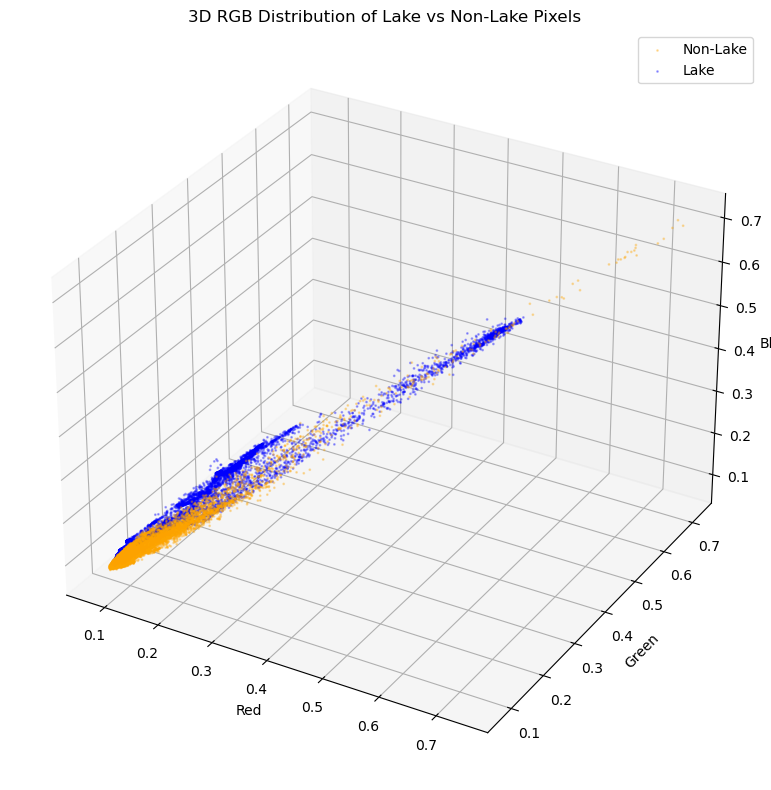

In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# === PATHS ===
images_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/training/images"
masks_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/training/masks"

# === DATA STORAGE ===
lake_rgb = []
nonlake_rgb = []

image_files = sorted(os.listdir(images_dir))

# === SAMPLING CONTROL ===
MAX_SAMPLES_PER_CLASS = 10000

for file in tqdm(image_files):
    image_path = os.path.join(images_dir, file)
    mask_path = os.path.join(masks_dir, file)

    with rasterio.open(image_path) as src:
        img = src.read([1, 2, 3]).astype(np.float32)  # Read R, G, B

    with rasterio.open(mask_path) as src:
        mask = src.read(1).astype(bool)

    r, g, b = img[0], img[1], img[2]

    # Extract pixels
    lake = np.stack([r[mask], g[mask], b[mask]], axis=1)
    nonlake = np.stack([r[~mask], g[~mask], b[~mask]], axis=1)

    lake_rgb.append(lake)
    nonlake_rgb.append(nonlake)

    # Early stop if enough data
    if sum(len(l) for l in lake_rgb) > MAX_SAMPLES_PER_CLASS and sum(len(nl) for nl in nonlake_rgb) > MAX_SAMPLES_PER_CLASS:
        break

# Stack and sample
lake_rgb = np.vstack(lake_rgb)
nonlake_rgb = np.vstack(nonlake_rgb)

np.random.shuffle(lake_rgb)
np.random.shuffle(nonlake_rgb)

lake_rgb = lake_rgb[:MAX_SAMPLES_PER_CLASS]
nonlake_rgb = nonlake_rgb[:MAX_SAMPLES_PER_CLASS]

# === PLOT ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(nonlake_rgb[:, 0], nonlake_rgb[:, 1], nonlake_rgb[:, 2], 
           color='orange', label='Non-Lake', alpha=0.3, s=1)

ax.scatter(lake_rgb[:, 0], lake_rgb[:, 1], lake_rgb[:, 2], 
           color='blue', label='Lake', alpha=0.3, s=1)

ax.set_xlabel('Red')
ax.set_ylabel('Green')
ax.set_zlabel('Blue')
ax.set_title('3D RGB Distribution of Lake vs Non-Lake Pixels')
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
import numpy as np

# === STATISTICAL SEPARABILITY METRICS ===

# Mean and covariance
mu_lake = np.mean(lake_rgb, axis=0)
mu_nonlake = np.mean(nonlake_rgb, axis=0)

cov_lake = np.cov(lake_rgb, rowvar=False)
cov_nonlake = np.cov(nonlake_rgb, rowvar=False)

# === 1. Euclidean Distance ===
euclidean_dist = np.linalg.norm(mu_lake - mu_nonlake)

# === 2. Bhattacharyya Distance ===
cov_avg = (cov_lake + cov_nonlake) / 2
diff_mu = mu_lake - mu_nonlake
term1 = 0.125 * diff_mu.T @ np.linalg.inv(cov_avg) @ diff_mu
term2 = 0.5 * np.log(np.linalg.det(cov_avg) / np.sqrt(np.linalg.det(cov_lake) * np.linalg.det(cov_nonlake)))
bhattacharyya_dist = term1 + term2

# === 3. Mahalanobis Distance ===
# Use pooled covariance
pooled_cov = (cov_lake + cov_nonlake) / 2
inv_pooled_cov = inv(pooled_cov)
mahal_dist = mahalanobis(mu_lake, mu_nonlake, inv_pooled_cov)

# === PRINT RESULTS ===
print(f"Euclidean Distance (RGB):       {euclidean_dist:.4f}")
print(f"Bhattacharyya Distance (RGB):   {bhattacharyya_dist:.4f}")
print(f"Mahalanobis Distance (RGB):     {mahal_dist:.4f}")


Euclidean Distance (RGB):       0.1279
Bhattacharyya Distance (RGB):   1.0215
Mahalanobis Distance (RGB):     1.7144


![Screenshot from 2025-04-06 13-46-48.png](<attachment:Screenshot from 2025-04-06 13-46-48.png>)

In [ ]:
import os
import rasterio

# List of your 6 Landsat mosaic file paths
mosaic_files = [
    "/home/user/Documents/2017/range_mosaics/eastern_himalaya/eastern_himalaya_clipped.TIF",
    "/home/user/Documents/2017/range_mosaics/central_himalaya/central_himalaya_clipped.TIF",
    "/home/user/Documents/2017/range_mosaics/karakoram/karakoram_combined.TIF",
    "/home/user/Documents/2017/range_mosaics/western_himalaya/western_himalaya_clipped.TIF",
    "/home/user/Documents/2017/range_mosaics/nyainqentanglha/nyainqentanglha_clipped.TIF",
    "/home/user/Documents/2017/range_mosaics/gangdise_mountains/gangdise_mountains_clipped.TIF"
]

# Dictionary to store min and max for each band in each file
band_stats = {}

# Process each file
for file in mosaic_files:
    try:
        with rasterio.open(file) as dataset:
            band_stats[file] = []
            
            for band in range(1, dataset.count + 1):  # dataset.count gives number of bands
                band_data = dataset.read(band)
                min_val, max_val = band_data.min(), band_data.max()
                band_stats[file].append((min_val, max_val))
    
    except Exception as e:
        print(f"Error opening {file}: {e}")

# Display results side by side
print("\nComparison of Min/Max Values Across Landsat Mosaics:\n")
header = ["Band"] + [os.path.basename(f) for f in mosaic_files]
print("{:<6}".format("Band"), end=" ")

# Print column headers
for f in mosaic_files:
    print("{:<30}".format(os.path.basename(f)), end=" ")
print("\n" + "-" * (len(mosaic_files) * 30))

# Print min/max values for each band side by side
num_bands = max([len(stats) for stats in band_stats.values()])  # Find max bands in any image
for band in range(num_bands):
    print("{:<6}".format(band + 1), end=" ")
    for file in mosaic_files:
        if file in band_stats and band < len(band_stats[file]):
            min_val, max_val = band_stats[file][band]
            print("Min: {:<8.2f} Max: {:<8.2f}".format(min_val, max_val), end=" ")
        else:
            print(" " * 25, end=" ")  # Empty space for missing bands
    print()  # New line for next band



Comparison of Min/Max Values Across Landsat Mosaics:

Band   eastern_himalaya_clipped.TIF   central_himalaya_clipped.TIF   karakoram_combined.TIF         western_himalaya_clipped.TIF   nyainqentanglha_clipped.TIF    gangdise_mountains_clipped.TIF 
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1      Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 
2      Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 
3      Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 Min: 0.00     Max: 65535.00 
4      Min: 0.00     Max: 65535.00 Min: 0.


Comparison of Min/Max Values After Masking:

Band   Eastern Himalaya               Central Himalaya               Eastern Hindu Kush             Western Himalaya               Nyainqentanglha                Gangdise Mountains             
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
1      Min: 4601.00  Max: 42785.00 Min: 5031.00  Max: 50790.00 Min: 5482.00  Max: 48950.00 Min: 5439.00  Max: 53315.00 Min: 4583.00  Max: 65535.00 Min: 5506.00  Max: 54106.00 
2      Min: 4990.00  Max: 41098.00 Min: 5049.00  Max: 48343.00 Min: 5301.00  Max: 47649.00 Min: 5671.00  Max: 50927.00 Min: 4915.00  Max: 62449.00 Min: 5657.00  Max: 51751.00 
3      Min: 5254.00  Max: 40634.00 Min: 5278.00  Max: 48231.00 Min: 5602.00  Max: 49832.00 Min: 5747.00  Max: 51151.00 Min: 5029.00  Max: 62092.00 Min: 5432.00  Max: 52171.00 
4      Min: 4746.00  Max: 43690.00 Min: 4877.00  Ma

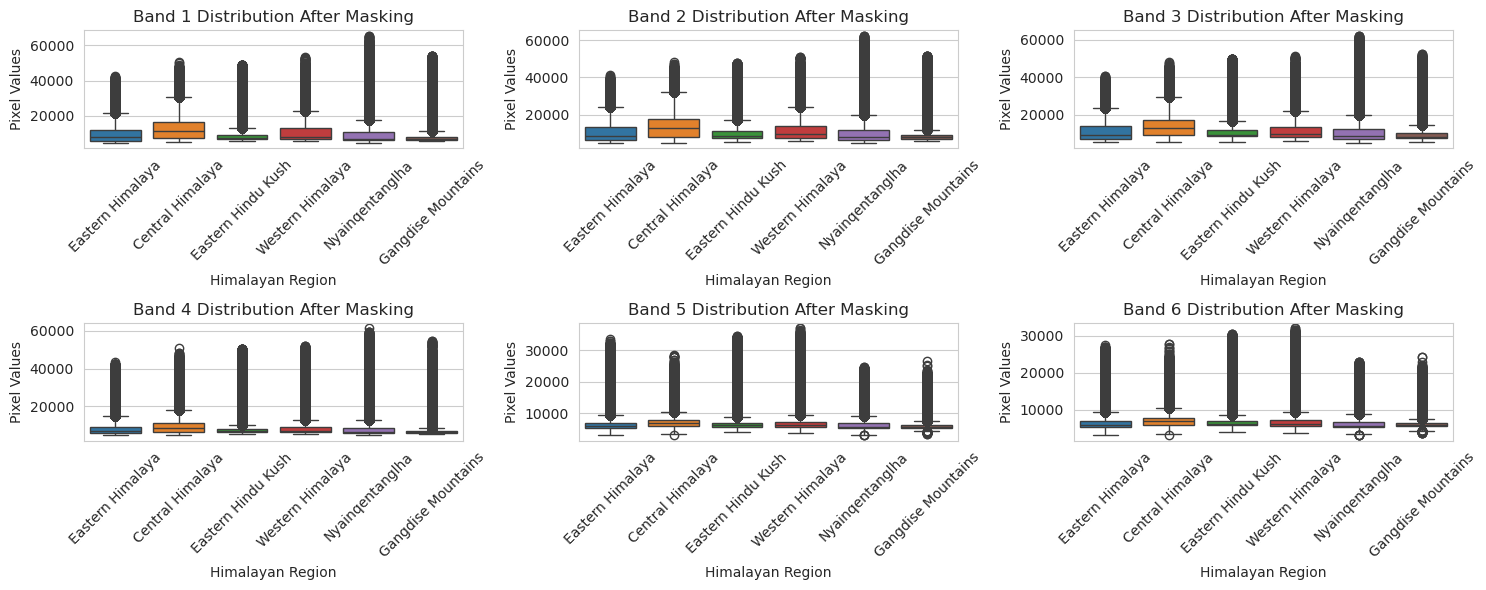

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
import matplotlib.pyplot as plt
import seaborn as sns

# List of Landsat mosaics and their corresponding mask mosaics
mosaic_files = {
    "Eastern Himalaya": {
        "landsat": "/home/user/Documents/2017/range_mosaics/eastern_himalaya/eastern_himalaya_clipped.TIF",
        "mask": "/home/user/Documents/2017/dataset/128/latest_dataset/eastern_himalaya-128/masks_mosaic.TIF"
    },
    "Central Himalaya": {
        "landsat": "/home/user/Documents/2017/range_mosaics/central_himalaya/central_himalaya_clipped.TIF",
        "mask": "/home/user/Documents/2017/dataset/128/latest_dataset/central_himalaya-128/masks_mosaic.TIF"
    },
    "Eastern Hindu Kush": {  # Replaced Karakoram with Eastern Hindu Kush
        "landsat": "/home/user/Documents/2017/range_mosaics/eastern_hindu_kush/eastern_hindu_kush_clipped.TIF",
        "mask": "/home/user/Documents/2017/dataset/128/latest_dataset/eastern_hindu_kush-128/masks_mosaic.TIF"
    },
    "Western Himalaya": {
        "landsat": "/home/user/Documents/2017/range_mosaics/western_himalaya/western_himalaya_clipped.TIF",
        "mask": "/home/user/Documents/2017/dataset/128/latest_dataset/western_himalaya-128/masks_mosaic.TIF"
    },
    "Nyainqentanglha": {
        "landsat": "/home/user/Documents/2017/range_mosaics/nyainqentanglha/nyainqentanglha_clipped.TIF",
        "mask": "/home/user/Documents/2017/dataset/128/latest_dataset/nyainqentanglha-128/masks_mosaic.TIF"
    },
    "Gangdise Mountains": {
        "landsat": "/home/user/Documents/2017/range_mosaics/gangdise_mountains/gangdise_mountains_clipped.TIF",
        "mask": "/home/user/Documents/2017/dataset/128/latest_dataset/gangdise_mountains-128/masks_mosaic.TIF"
    }
}

# Dictionary to store min and max values after applying the mask
band_stats = {}
masked_band_data = {}

# Function to reproject mask to match Landsat image
def reproject_mask(mask_dataset, landsat_dataset):
    """Reproject mask to match Landsat mosaic."""
    mask_data = mask_dataset.read(1)  # Read first band (binary mask)
    mask_reprojected = np.zeros_like(landsat_dataset.read(1))  # Empty array for reprojected mask
    
    reproject(
        source=mask_data,
        destination=mask_reprojected,
        src_transform=mask_dataset.transform,
        src_crs=mask_dataset.crs,
        dst_transform=landsat_dataset.transform,
        dst_crs=landsat_dataset.crs,
        resampling=Resampling.nearest
    )
    
    return mask_reprojected

# Process each region
for region, paths in mosaic_files.items():
    try:
        with rasterio.open(paths["landsat"]) as landsat_ds, rasterio.open(paths["mask"]) as mask_ds:
            
            # Reproject mask to match Landsat resolution & extent
            mask_reprojected = reproject_mask(mask_ds, landsat_ds)
            mask_reprojected = (mask_reprojected > 0).astype(np.uint8)  # Convert to binary (0,1)

            band_stats[region] = []
            masked_band_data[region] = []

            # Apply mask to each Landsat band
            for band in range(1, landsat_ds.count + 1):
                band_data = landsat_ds.read(band)  # Read Landsat band
                masked_band = band_data * mask_reprojected  # Multiply with binary mask
                
                # Filter out zeros (unmasked areas)
                valid_pixels = masked_band[masked_band > 0]
                
                if len(valid_pixels) > 0:
                    min_val, max_val = valid_pixels.min(), valid_pixels.max()
                    masked_band_data[region].append(valid_pixels)  # Store for box plot
                else:
                    min_val, max_val = np.nan, np.nan  # No valid pixels
                
                band_stats[region].append((min_val, max_val))

    except Exception as e:
        print(f"Error processing {region}: {e}")

# Print min/max values after applying the mask
print("\nComparison of Min/Max Values After Masking:\n")
header = ["Band"] + list(mosaic_files.keys())
print("{:<6}".format("Band"), end=" ")

# Print column headers
for region in mosaic_files.keys():
    print("{:<30}".format(region), end=" ")
print("\n" + "-" * (len(mosaic_files) * 30))

# Print min/max values for each band side by side
num_bands = max([len(stats) for stats in band_stats.values()])  # Find max bands in any image
for band in range(num_bands):
    print("{:<6}".format(band + 1), end=" ")
    for region in mosaic_files.keys():
        if region in band_stats and band < len(band_stats[region]):
            min_val, max_val = band_stats[region][band]
            print("Min: {:<8.2f} Max: {:<8.2f}".format(min_val, max_val), end=" ")
        else:
            print(" " * 25, end=" ")  # Empty space for missing bands
    print()  # New line for next band

# Box plots for each band's distribution
sns.set_style("whitegrid")
plt.figure(figsize=(15, 6))

for band_idx in range(num_bands):
    band_values = []
    labels = []
    
    for region, bands in masked_band_data.items():
        if band_idx < len(bands):  # Ensure the band exists
            band_values.append(bands[band_idx])
            labels.append(region)
    
    # Box plot for this band
    plt.subplot(2, (num_bands + 1) // 2, band_idx + 1)
    sns.boxplot(data=band_values)
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    plt.ylabel("Pixel Values")
    plt.xlabel("Himalayan Region")
    plt.title(f"Band {band_idx + 1} Distribution After Masking")

plt.tight_layout()
plt.show()


# Counting the lake pixles inn each range 

In [ ]:
import os
import numpy as np
import rasterio
from skimage.measure import label, regionprops

# Only mask paths per region
mask_paths = {
    "Eastern Himalaya": "/home/user/Documents/2017/dataset/128/latest_dataset/eastern_himalaya-128/1.start/masks_mosaic.TIF",
    "Central Himalaya": "/home/user/Documents/2017/dataset/128/latest_dataset/central_himalaya-128/1.start/masks_mosaic.TIF",
    "Eastern Hindu Kush": "/home/user/Documents/2017/dataset/128/latest_dataset/eastern_hindu_kush-128/masks_mosaic.TIF",
    "Western Himalaya": "/home/user/Documents/2017/dataset/128/latest_dataset/western_himalaya-128/masks_mosaic.TIF",
    "Nyainqentanglha": "/home/user/Documents/2017/dataset/128/latest_dataset/nyainqentanglha-128/masks_mosaic.TIF",
    "Gangdise Mountains": "/home/user/Documents/2017/dataset/128/latest_dataset/gangdise_mountains-128/masks_mosaic.TIF"
}
# Thresholds for small lakes
small_thresholds = [35, 30, 25, 20, 15, 10]
large_threshold = 16384  # 128x128 patch

print("\nLake Pixel Count Summary per Region:\n")
header = (
    "{:<25} {:<10} {:<10} {:<10}".format("Region", "NumLakes", "MinPix", "MaxPix") +
    "".join(["{:<8}".format(f"<{t}") for t in small_thresholds]) +
    "{:<10}".format(f">{large_threshold}")
)
print(header)
print("-" * len(header))

for region, mask_path in mask_paths.items():
    try:
        with rasterio.open(mask_path) as src:
            mask = src.read(1)
            mask = (mask > 0).astype(np.uint8)

            labeled = label(mask)
            regions = regionprops(labeled)

            num_lakes = len(regions)
            if num_lakes == 0:
                min_pixels = max_pixels = 0
                counts_below_thresh = [0] * len(small_thresholds)
                count_above_large = 0
            else:
                areas = [r.area for r in regions]
                min_pixels = min(areas)
                max_pixels = max(areas)
                counts_below_thresh = [sum(a < t for a in areas) for t in small_thresholds]
                count_above_large = sum(a > large_threshold for a in areas)

            row = (
                "{:<25} {:<10} {:<10} {:<10}".format(region, num_lakes, min_pixels, max_pixels) +
                "".join(["{:<8}".format(c) for c in counts_below_thresh]) +
                "{:<10}".format(count_above_large)
            )
            print(row)

    except Exception as e:
        print(f"Error processing {region}: {e}")




Lake Pixel Count Summary per Region:

Region                    NumLakes   MinPix     MaxPix    <35     <30     <25     <20     <15     <10     >16384    
--------------------------------------------------------------------------------------------------------------------
Eastern Himalaya          2100       1.0        101336.0  5       3       2       2       2       2       3         
Central Himalaya          2114       31.0       14618.0   6       0       0       0       0       0       0         
Eastern Hindu Kush        1478       1.0        8656.0    2       2       2       2       2       2       0         
Western Himalaya          1000       34.0       74411.0   1       0       0       0       0       0       5         
Nyainqentanglha           2665       1.0        119376.0  4       1       1       1       1       1       5         
Gangdise Mountains        1216       34.0       97700.0   3       0       0       0       0       0       5         


# metrics for per lake wise 

## Copy the meta data

In [ ]:
import os
import rasterio
import numpy as np

def copy_metadata_inplace(mask1_dir, mask2_dir):
    """
    Copy metadata from mask1 files to mask2 files and overwrite mask2 files.

    Args:
        mask1_dir (str): Directory containing mask1 files with metadata.
        mask2_dir (str): Directory containing mask2 files without metadata.
    """
    for filename in os.listdir(mask1_dir):
        if filename.endswith(".TIF"):
            mask1_path = os.path.join(mask1_dir, filename)
            mask2_path = os.path.join(mask2_dir, filename)

            # Check if the corresponding file exists in mask2
            if not os.path.exists(mask2_path):
                print(f"File {filename} not found in {mask2_dir}. Skipping.")
                continue

            # Read metadata from mask1
            with rasterio.open(mask1_path) as src1:
                meta = src1.meta.copy()

            # Read data from mask2
            with rasterio.open(mask2_path) as src2:
                data = src2.read()

            # Update the metadata for the mask2 file
            meta.update({
                "driver": "GTiff",
                "height": data.shape[1],
                "width": data.shape[2],
                "count": data.shape[0],
                "dtype": data.dtype
            })

            # Overwrite the mask2 file with updated metadata
            with rasterio.open(mask2_path, "w", **meta) as dst:
                dst.write(data)

            print(f"Metadata copied and updated for {filename}.")

# Example usage
mask1_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/masks"
mask2_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/out"
copy_metadata_inplace(mask1_dir, mask2_dir)


Metadata copied and updated for 1485.TIF.
Metadata copied and updated for 1471.TIF.
Metadata copied and updated for 1259.TIF.
Metadata copied and updated for 672.TIF.
Metadata copied and updated for 1324.TIF.
Metadata copied and updated for 554.TIF.
Metadata copied and updated for 1745.TIF.
Metadata copied and updated for 1591.TIF.
Metadata copied and updated for 1131.TIF.
Metadata copied and updated for 1718.TIF.
Metadata copied and updated for 1185.TIF.
Metadata copied and updated for 1088.TIF.
Metadata copied and updated for 1787.TIF.
Metadata copied and updated for 909.TIF.
Metadata copied and updated for 1707.TIF.
Metadata copied and updated for 677.TIF.
Metadata copied and updated for 295.TIF.
Metadata copied and updated for 663.TIF.
Metadata copied and updated for 1727.TIF.
Metadata copied and updated for 2021.TIF.
Metadata copied and updated for 1237.TIF.
Metadata copied and updated for 713.TIF.
Metadata copied and updated for 486.TIF.
Metadata copied and updated for 1809.TIF.


## creating mosiac

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.merge import merge

def create_mosaic(mask_dir, output_path):
    """
    Create a mosaic of binary masks using a logical OR operation for overlapping pixels.

    Args:
        mask_dir (str): Directory containing binary mask GeoTIFF files.
        output_path (str): Path to save the output mosaic GeoTIFF.
    """
    mask_files = [os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(".TIF")]
    if not mask_files:
        raise ValueError("No GeoTIFF files found in the specified directory.")

    # List to hold opened datasets
    datasets = []

    # Open each mask and append to the dataset list
    for mask_file in mask_files:
        src = rasterio.open(mask_file)
        datasets.append(src)

    # Use rasterio's merge function to align and combine masks
    mosaic, transform = merge(datasets, method='first')

    # Apply logical OR across all layers
    final_mask = np.any(mosaic, axis=0).astype(np.uint8)

    # Save the mosaic mask to a new GeoTIFF
    out_meta = datasets[0].meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": final_mask.shape[0],
        "width": final_mask.shape[1],
        "transform": transform,
        "count": 1,
        "dtype": 'uint8'
    })

    with rasterio.open(output_path, "w", **out_meta) as dst:
        dst.write(final_mask, 1)

    # Close datasets
    for src in datasets:
        src.close()


# for inner in os.listdir(outer_folder_path):
mask_dir = f"/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/out"
output_path = f"/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/out.TIF"
create_mosaic(mask_dir, output_path)


## Reprojection

In [ ]:
import rasterio
from rasterio.warp import reproject, Resampling

# Input file paths
landsat_mosaic_path = "//home/user/Documents/2017/range_mosaics/eastern_himalaya/eastern_himalaya_clipped.TIF"  # Path to the Landsat mosaic
mask_mosaic_path = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/out.TIF"  # Path to the out mosaic
output_mask_aligned_path = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/out.TIF"  # Output path for the reprojected mask mosaic

# Open the Landsat mosaic to extract its CRS and transform
with rasterio.open(landsat_mosaic_path) as landsat_src:
    landsat_crs = landsat_src.crs  # Coordinate Reference System
    landsat_transform = landsat_src.transform  # Affine transformation
    landsat_res = landsat_src.res  # Resolution (x, y)
    landsat_width = landsat_src.width  # Width in pixels
    landsat_height = landsat_src.height  # Height in pixels

# Open the mask mosaic
with rasterio.open(mask_mosaic_path) as mask_src:
    mask_data = mask_src.read(1)  # Read the first band (modify if multi-band)
    mask_profile = mask_src.profile  # Copy the metadata

    # Update metadata to match the Landsat mosaic
    mask_profile.update(
        crs=landsat_crs,
        transform=landsat_transform,
        width=landsat_width,
        height=landsat_height,
        compress='lzw'  # Optional: compression for output
    )

    # Reproject the mask data to align it with the Landsat mosaic
    with rasterio.open(output_mask_aligned_path, "w", **mask_profile) as dst:
        reproject(
            source=mask_data,
            destination=rasterio.band(dst, 1),
            src_transform=mask_src.transform,
            src_crs=mask_src.crs,
            dst_transform=landsat_transform,
            dst_crs=landsat_crs,
            resampling=Resampling.nearest  # Resampling method, change if needed
        )

print("Reprojection and alignment completed. Aligned mask mosaic saved to:", output_mask_aligned_path)


Reprojection and alignment completed. Aligned mask mosaic saved to: /home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/out.TIF


## Mosaci metric calculation

In [ ]:
import rasterio
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Paths to the mask mosaics
ground_truth_path = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/final_model_all/sam_model_all_bands/mask_mosiac.TIF"
predicted_path = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/final_model_all/sam_model_all_bands/out.TIF"

# Open the ground truth and predicted masks
with rasterio.open(ground_truth_path) as gt_src, rasterio.open(predicted_path) as pred_src:
    # Read the data (assuming single-band binary masks: 0 = background, 1 = object)
    gt_mask = gt_src.read(1).astype(np.uint8)  # Ground truth mask
    pred_mask = pred_src.read(1).astype(np.uint8)  # Predicted mask

    # Ensure both masks have the same shape
    if gt_mask.shape != pred_mask.shape:
        raise ValueError("Ground truth and predicted masks must have the same dimensions!")

    # Flatten the arrays for calculation
    gt_flat = gt_mask.ravel()
    pred_flat = pred_mask.ravel()

    # Calculate intersection and union for IoU
    intersection = np.logical_and(gt_flat, pred_flat).sum()
    union = np.logical_or(gt_flat, pred_flat).sum()
    iou = intersection / union if union != 0 else 0

    # Calculate precision, recall, and F1-score using sklearn
    precision = precision_score(gt_flat, pred_flat, average='binary')
    recall = recall_score(gt_flat, pred_flat, average='binary')
    f1 = f1_score(gt_flat, pred_flat, average='binary')

    # Print the results
    print("Metrics between Ground Truth and Predicted Masks:")
    print(f"IoU: {iou:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


## per lake wise

In [ ]:
import numpy as np
import rasterio
from scipy.ndimage import label
import pandas as pd

def calculate_metrics(gt_mask, pred_mask):
    """
    Calculate IoU, precision, recall, and F1 score for a single lake.
    """
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()

    # IoU
    iou = intersection / union if union != 0 else 0

    # Precision, Recall, F1-Score
    precision = intersection / pred_mask.sum() if pred_mask.sum() != 0 else 0
    recall = intersection / gt_mask.sum() if gt_mask.sum() != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return iou, precision, recall, f1

def analyze_lakes(ground_truth, predicted, padding=2):
    """
    Analyze each lake in the ground truth and calculate metrics, with padding around bounding boxes.
    """
    # Label connected components in the ground truth
    labeled_gt, num_features_gt = label(ground_truth)
    labeled_pred, num_features_pred = label(predicted)

    metrics = []
    for lake_id in range(1, num_features_gt + 1):  # Start from 1 (background is 0)
        # Create binary mask for the current lake
        gt_mask = (labeled_gt == lake_id)

        # Get bounding box coordinates
        rows, cols = np.where(gt_mask)
        if len(rows) == 0 or len(cols) == 0:
            continue
        min_row, max_row = rows.min(), rows.max()
        min_col, max_col = cols.min(), cols.max()

        # Apply padding
        min_row = max(min_row - padding, 0)
        max_row = min(max_row + padding, ground_truth.shape[0] - 1)
        min_col = max(min_col - padding, 0)
        max_col = min(max_col + padding, ground_truth.shape[1] - 1)

        # Extract bounding box from ground truth and predicted
        gt_bbox = gt_mask[min_row:max_row + 1, min_col:max_col + 1]
        pred_bbox = predicted[min_row:max_row + 1, min_col:max_col + 1]

        # Calculate metrics for the lake
        iou, precision, recall, f1 = calculate_metrics(gt_bbox, pred_bbox)

        # Store metrics
        metrics.append({
            'Lake ID': lake_id,
            'IoU': iou,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Ground Truth Pixels': gt_mask.sum(),
            'Predicted Pixels': pred_bbox.sum()
        })

    # False positives: Identify predicted regions with no overlap in ground truth
    false_positive_mask = np.logical_and(predicted > 0, ground_truth == 0)
    false_positive_pixels = false_positive_mask.sum()
    total_predicted_pixels = predicted.sum()
    false_positive_percentage = (false_positive_pixels / total_predicted_pixels * 100) if total_predicted_pixels != 0 else 0

    return metrics, false_positive_pixels, false_positive_percentage




# Load mosaics
def load_mosaic(file_path):
    with rasterio.open(file_path) as src:
        data = src.read(1).astype(bool)  # Convert to boolean for binary mask
    return data

# Paths to mosaic files
ground_truth_file = "//home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/final_model_all/sam_model_all_bands/mask_mosiac.TIF"
predicted_file = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/final_model_all/sam_model_all_bands/out.TIF"

# Load data
ground_truth_mosaic = load_mosaic(ground_truth_file)
predicted_mosaic = load_mosaic(predicted_file)

# Analyze lakes and calculate metrics
lake_metrics, false_positive_pixels,false_positive_percentage = analyze_lakes(ground_truth_mosaic, predicted_mosaic)

# Save results to a DataFrame
df = pd.DataFrame(lake_metrics)
df['False Positive Pixels'] = false_positive_pixels
df['False Positive Percentage'] = false_positive_percentage

# Save results to an Excel file
# output_excel_file = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/simple_sam.xlsx"
# df.to_excel(output_excel_file, index=False)

# Print summary
# Print summary
# print(f"Metrics saved to {output_excel_file}.")
print(f"Total False Positive Pixels in Predicted Mosaic: {false_positive_pixels}")
print(f"False Positive Percentage: {false_positive_percentage:.2f}%")


Total False Positive Pixels in Predicted Mosaic: 13191
False Positive Percentage: 9.21%


Metrics saved to /home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/simple_sam.xlsx.
Total False Positive Pixels in Predicted Mosaic: 11765
False Positive Percentage: 8.41% in simple sam

# Comparison Image Drawing


In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from glob import glob

# Directories
image_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/test/images"
gt_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/test/masks"
base_mask_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/models_of_65536/base_model_65536/model_out/witout_post"
simple_cnn = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/simple_cnn_model/test/prompt/witout_post"
ssnau_mask_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/models_of_65536/NAU_Net_slope_aware_ndwi_ndsi_nir_swir1_swir2/model_out/witout_post"
ssnau_sam9_mask_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/final_model_all/sam_model_all_bands/out"

output_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/comp"
os.makedirs(output_dir, exist_ok=True)

# Color map: TP=Green, FP=Red, TN=Black, FN=Blue
def get_diff_map(pred, gt):
    TP = (pred == 1) & (gt == 1)
    FP = (pred == 1) & (gt == 0)
    TN = (pred == 0) & (gt == 0)
    FN = (pred == 0) & (gt == 1)

    out = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
    out[TP] = [0, 255, 0]   # Green
    out[FP] = [255, 0, 0]   # Red
    out[TN] = [0, 0, 0]     # Black
    out[FN] = [0, 0, 255]   # Blue
    return out

# Utility to read masks
def read_mask(path):
    with rasterio.open(path) as src:
        mask = src.read(1)
    return (mask > 0).astype(np.uint8)  # Binarize

# Read images
image_paths = sorted(glob(os.path.join(image_dir, "*.TIF")))

for image_path in image_paths:
    name = os.path.basename(image_path)
    image_name = os.path.splitext(name)[0]  # Remove .TIF extension

    # Read image and masks
    with rasterio.open(image_path) as src:
        image = np.transpose(src.read([1, 2, 3]), (1, 2, 0))  # RGB

    gt_mask = read_mask(os.path.join(gt_dir, name))
    base_mask = read_mask(os.path.join(base_mask_dir, name))
    snau_mask = read_mask(os.path.join(simple_cnn, name))
    ssnau_mask = read_mask(os.path.join(ssnau_mask_dir, name))
    ssnau_sam9_mask = read_mask(os.path.join(ssnau_sam9_mask_dir, name))

    # Get diff maps
    base_diff = get_diff_map(base_mask, gt_mask)
    snau_diff = get_diff_map(snau_mask, gt_mask)
    ssnau_diff = get_diff_map(ssnau_mask, gt_mask)
    ssnau_sam9_diff = get_diff_map(ssnau_sam9_mask, gt_mask)

    # Plot all
    fig, axs = plt.subplots(1, 6, figsize=(27, 4))
    axs[0].imshow(image)
    axs[0].set_title(image_name)  # Use file name

    axs[1].imshow(base_diff)
    axs[1].set_title("Base Model")

    axs[2].imshow(snau_diff)
    axs[2].set_title("Simple-CNN")

    axs[3].imshow(ssnau_diff)
    axs[3].set_title("S-S-NAU-Net")

    axs[4].imshow(ssnau_sam9_diff)
    axs[4].set_title("S-S-NAU-Net + SAM(9)")

    axs[5].imshow(gt_mask, cmap='gray')
    axs[5].set_title("Ground Truth")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, image_name + '_comparison.png'))
    plt.close()


In [ ]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from glob import glob

# Directories
image_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/test/images"
gt_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/test/masks"

base_mask_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/models_of_65536/base_model_65536/model_out/witout_post"
simple_cnn_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/simple_cnn_model/test/prompt/witout_post"
snau_net_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/models_of_65536/slope_aware_naunet_vishal/witout_post"
ssnau_net_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/5.divideby65536/models_of_65536/NAU_Net_slope_aware_ndwi_ndsi_nir_swir1_swir2/test/prompt/witout_post"

simple_cnn_sam_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/simple_cnn_model/final_model_all/sam_model_all_bands/out"
ssnau_sam_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/final_model_all/sam_model_all_bands/out"

output_dir = "/home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/comp"
os.makedirs(output_dir, exist_ok=True)

# Function to get diff map
def get_diff_map(pred, gt):
    TP = (pred == 1) & (gt == 1)
    FP = (pred == 1) & (gt == 0)
    TN = (pred == 0) & (gt == 0)
    FN = (pred == 0) & (gt == 1)
    out = np.zeros((gt.shape[0], gt.shape[1], 3), dtype=np.uint8)
    out[TP] = [0, 255, 0]   # Green
    out[FP] = [255, 0, 0]   # Red
    out[TN] = [0, 0, 0]     # Black
    out[FN] = [0, 0, 255]   # Blue
    return out

# Mask reader
def read_mask(path):
    with rasterio.open(path) as src:
        mask = src.read(1)
    return (mask > 0).astype(np.uint8)

# Image loop
image_paths = sorted(glob(os.path.join(image_dir, "*.TIF")))

for image_path in image_paths:
    name = os.path.basename(image_path)
    image_name = os.path.splitext(name)[0] 
    with rasterio.open(image_path) as src:
        image = np.transpose(src.read([1, 2, 3]), (1, 2, 0))

    gt_mask = read_mask(os.path.join(gt_dir, name))
    base_mask = read_mask(os.path.join(base_mask_dir, name))
    simple_cnn_mask = read_mask(os.path.join(simple_cnn_dir, name))
    snau_net_mask = read_mask(os.path.join(snau_net_dir, name))
    ssnau_net_mask = read_mask(os.path.join(ssnau_net_dir, name))
    simple_cnn_sam_mask = read_mask(os.path.join(simple_cnn_sam_dir, name))
    ssnau_sam_mask = read_mask(os.path.join(ssnau_sam_dir, name))

    # Diff maps
    base_diff = get_diff_map(base_mask, gt_mask)
    simple_cnn_diff = get_diff_map(simple_cnn_mask, gt_mask)
    snau_diff = get_diff_map(snau_net_mask, gt_mask)
    ssnau_diff = get_diff_map(ssnau_net_mask, gt_mask)
    simple_cnn_sam_diff = get_diff_map(simple_cnn_sam_mask, gt_mask)
    ssnau_sam_diff = get_diff_map(ssnau_sam_mask, gt_mask)

    # Plotting
    fig, axs = plt.subplots(1, 8, figsize=(40, 5))

    axs[0].imshow(image)
    axs[0].set_title(image_name)

    axs[1].imshow(base_diff)
    axs[1].set_title("Base Model")

    axs[2].imshow(simple_cnn_diff)
    axs[2].set_title("Simple-CNN")

    axs[3].imshow(snau_diff)
    axs[3].set_title("S-NAU-Net")

    axs[4].imshow(ssnau_diff)
    axs[4].set_title("S-S-NAU-Net")

    axs[5].imshow(simple_cnn_sam_diff)
    axs[5].set_title("Simple-CNN + SAM")

    axs[6].imshow(ssnau_sam_diff)
    axs[6].set_title("S-S-NAU-Net + SAM")

    axs[7].imshow(gt_mask, cmap='gray')
    axs[7].set_title("Ground Truth")

    for ax in axs:
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, os.path.splitext(name)[0] + '_comparison.png'))
    plt.close()


: 

## The End

Metrics saved to /home/user/Documents/2017/dataset/128/latest_dataset/greater_than_20_pixels/eastern_himalaya-128/final_model_all/sam_model_all_bands/final.xlsx.
Total False Positive Pixels in Predicted Mosaic: 13191
False Positive Percentage: 9.21%